# Size vs Cardinality for Bloom and Quotient Filters

We investigate the size of the filters as the cardinality of the input set increases.  
Linear space is required to solve the approximate set membership problem, so we expect the size of the filters to *increase* as the input cardinality increases for a fixed 
false positive rate (fpr).  However, we are interested in the relative performance of the Bloom and Quotient filters at a fixed false positive rate.  This enables us to contrast the performance of each filter.

## Experiment 1.  False Positive Rate $10^{-6}$

Fix a target false positive rate and then configure the filters appropriately for increasing input size $n$.
The Quotient filter has its number of slots rounded to the next power of two larger than the current $n$ and the Bloom filter is set optimally for any given $n$.
As a result, the Bloom filter results are as optimistic as can be.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from typing import Tuple
%matplotlib inline

In [3]:
def parse_size_results(filename:str) -> pd.DataFrame:
    with open(filename) as f:
        lines = f.readlines()[2:] # first two lines not needed
    ignore_from_idx = lines.index("PROPERTIES:\n")
    results = lines[:ignore_from_idx-1] # there is an empty line preceding the ignore_from_idx
    results_clean = [r.strip("\n") for r in results]
    results_df = pd.DataFrame(sub.split("\t") for sub in results_clean[1:])
    results_df.columns = results_clean[0].split("\t")
    results_df.rename(columns={"TrueU" : "inputCardinality"}, inplace=True)
    for col in results_df.columns:
        results_df[col] = pd.to_numeric(results_df[col])
    return results_df

In [4]:
bf_sizes = parse_size_results("1e-6/BloomFilterSizeProfile20240703_014140PST.txt")
qf_sizes = parse_size_results("1e-6/QuotientFilterSizeProfile20240703_014255PST_1E-6.txt") # 1e-6

for df in [bf_sizes, qf_sizes]:
    df["bitsPerElement"] = df["Size"] / df["inputCardinality"]

for qf in [qf_sizes]:
    qf["numSlots"] = np.ceil(np.log2(qf["inputCardinality"] / 0.9 )).astype(int) # nb this is because the suggestion function always uses 0.9 and may change in futuer.
    qf["loadFactor"] = qf["inputCardinality"] / (2**qf["numSlots"])

In [5]:
qf_sizes

,inputCardinality,Size,NumTrials,FalsePositiveRate,NumHashBits,bitsPerElement,numSlots,loadFactor
0,3,176,16384,9.536743e-07,20,58.666667,2,0.750000
1,4,184,10922,2.384186e-07,20,46.000000,3,0.500000
2,5,184,8192,4.768372e-07,20,36.800000,3,0.625000
3,6,184,6553,4.768372e-07,20,30.666667,3,0.750000
4,7,352,5461,2.384186e-07,20,50.285714,3,0.875000
...,...,...,...,...,...,...,...,...
169,794672,24117248,1024,1.192093e-06,20,30.348682,20,0.757858
170,851708,24117248,1024,1.192093e-06,20,28.316334,20,0.812252
171,912838,24117248,1024,2.384186e-07,20,26.420075,20,0.870550
172,978356,48234496,1024,7.152557e-07,20,49.301579,21,0.466516


In [7]:
# merged_df = pd.merge(bf_sizes, bf_sizes_less_one, on='inputCardinality')
# merged_df

Text(0.5, 1.0, 'Size (bits) vs Input Cardinality')

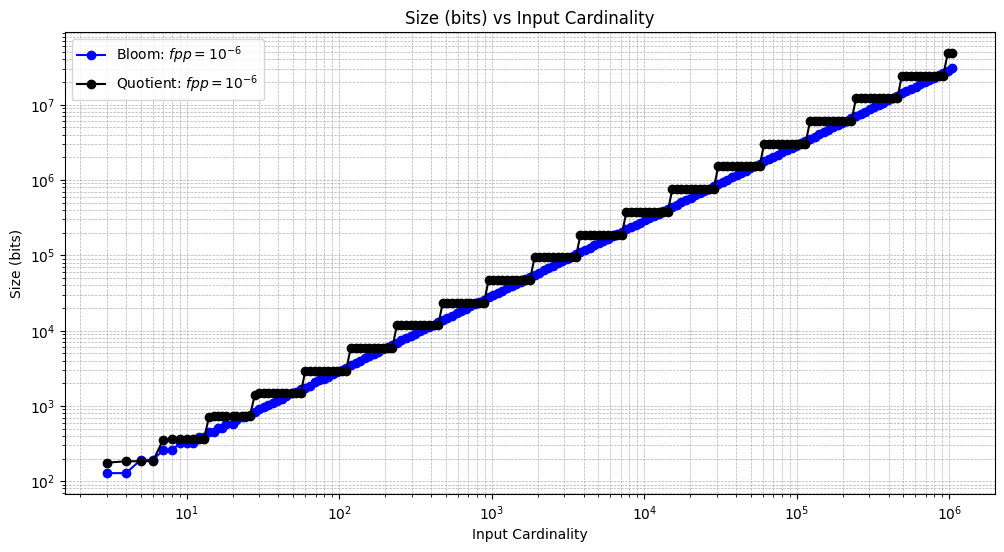

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
SCALE = 1
ax.plot(bf_sizes["inputCardinality"], bf_sizes["Size"]/SCALE, color="blue", marker="o", label=r"Bloom: $fpp = 10^{-6}$")

# Quotient 
ax.plot(qf_sizes["inputCardinality"], qf_sizes["Size"]/SCALE, color="black", marker="o", label=r"Quotient: $fpp = 10^{-6}$")
ax.legend()
ax.grid()
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_ylabel("Size (bits)")
ax.set_xlabel("Input Cardinality")
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.set_title("Size (bits) vs Input Cardinality")


Text(0.5, 1.0, 'Size (bits) vs Input Cardinality')

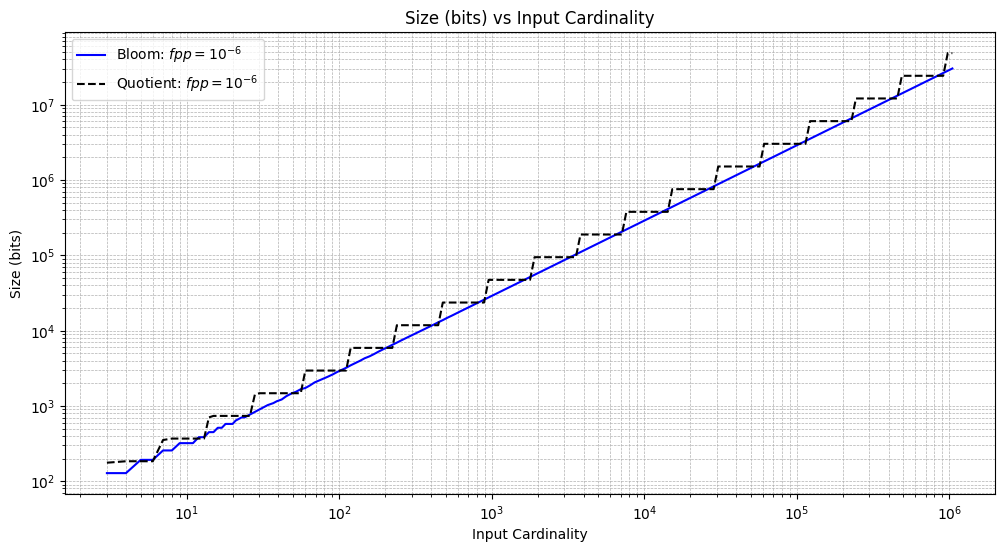

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))
SCALE = 1
ax.plot(bf_sizes["inputCardinality"], bf_sizes["Size"]/SCALE, color="blue", label=r"Bloom: $fpp = 10^{-6}$")
ax.plot(qf_sizes["inputCardinality"], qf_sizes["Size"]/SCALE, color="black", label=r"Quotient: $fpp = 10^{-6}$", linestyle="--")

ax.legend()
ax.grid()
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_ylabel("Size (bits)")
ax.set_xlabel("Input Cardinality")
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.set_title("Size (bits) vs Input Cardinality")
#fig.savefig("image/space-vs-cardinality.pdf")


Looking closely, we can see that there is a small regime where the Quotient filter space in bits seems to drop beneath that for the Bloom filter.  Let's zoom in on that region in the following plots.
First, we can see that as $n$ increases, the load factor is not constant.  The load factor is the ratio of the number of elements in the filter to the filter's length.  This behaviour is to be expected since the Quotient filter length must always be a power of two, so once a certain (parameterised) 
threshold is met, then the filter length must be doubled.  In this example, we see this behaviour in the vertical drops between about $90\%$ to $\approx 45\%$ load factor.

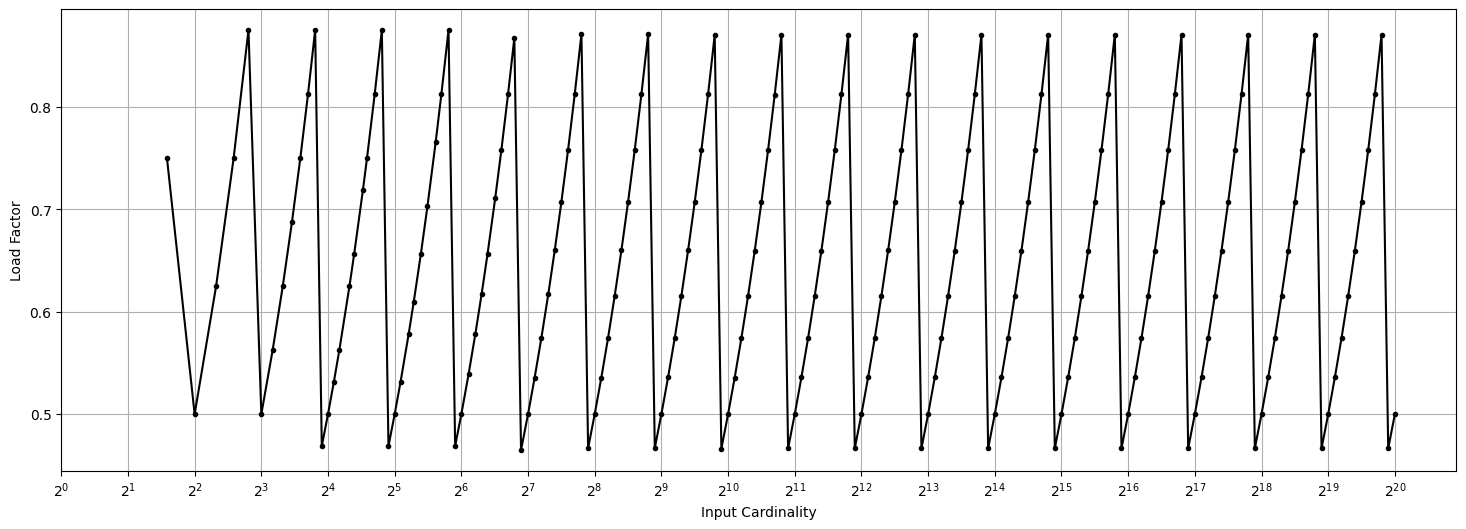

In [10]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(qf_sizes["inputCardinality"], qf_sizes["loadFactor"], color="black", marker=".", label=r"Size ratio")

ax.set_ylabel("Load Factor")
ax.set_xlabel("Input Cardinality")
ax.set_xscale("log", base=2)
ax.grid()
ax.set_xticks([2**i for i in range(0, 21)])

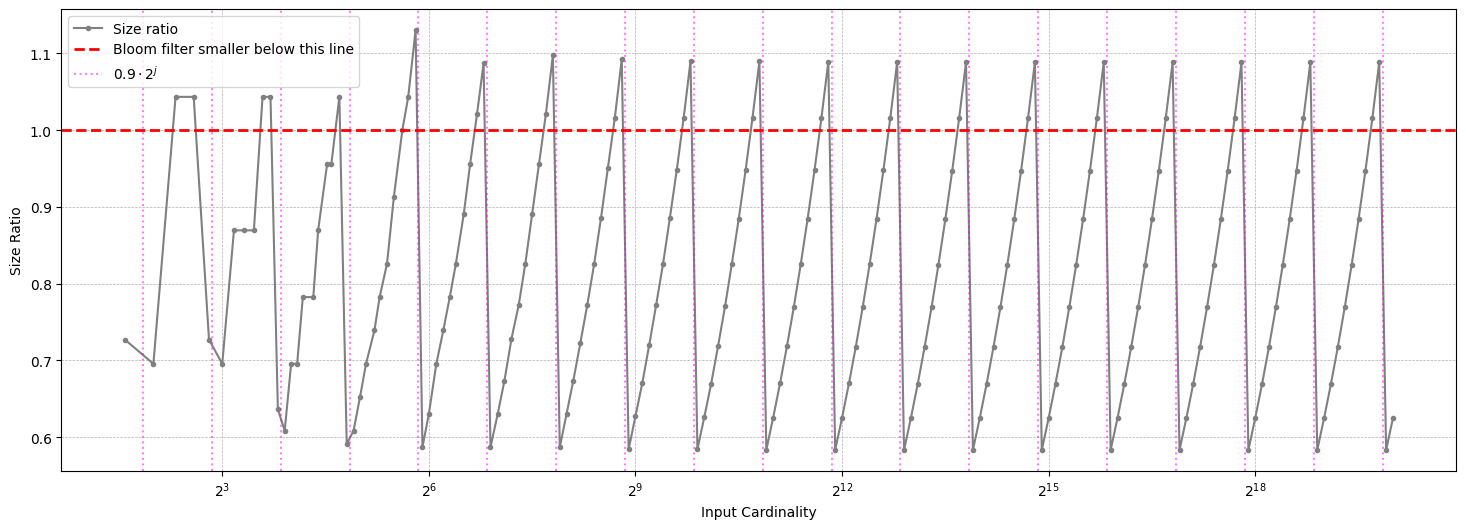

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(bf_sizes["inputCardinality"], bf_sizes["Size"]/qf_sizes["Size"], color="grey", marker=".", label=r"Size ratio")
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Bloom filter smaller below this line')



# Plot vertical lines at 0.9*2^j for each j where we double to length of the quotient filter
j_values = range(2, 21)
jval_col = "magenta"
ival_col = "skyblue"
for i, j in enumerate(j_values):
    x = 0.9 * 2**j
    if i == len(j_values) - 1:
        ax.axvline(x=x, color=jval_col, linestyle=':', alpha=0.5, label=r"$0.9 \cdot 2^j$")
    else:
        ax.axvline(x=x, color=jval_col, linestyle=':', alpha=0.5)


ax.legend()
ax.grid()
ax.set_xscale("log", base=2)
ax.set_ylabel("Size Ratio")
ax.set_xlabel("Input Cardinality")
ax.grid(which='both', linestyle='--', linewidth=0.5)
#fig.savefig("image/bloom-quotient-ratio.pdf")

We see that _for a fixed false positive rate_, the Bloom filter is smaller than the Quotient filter in most regimes, unless the Quotient filter close to, but not exceeding $90\%$.

### Experiment 1a.

We can also do a rough analysis of the false positive rate over input cardinalities (note that a more refined analysis will follow).
In this plot we see that the Bloom filter probability approximations do not work well in the small cardinality regime and then approach the $2^{-f}$ bound for large cardinalities.  On the other hand, the Quotient filter error behaviour consistently remains below the $2^{-f}$ probability error bound.  There are a small number of exceptions, but these are deferred for later analysis.

Text(0.5, 1.0, 'Measured False Positive Rate vs. Input Cardinality (zeros occur at non-uniform points)')

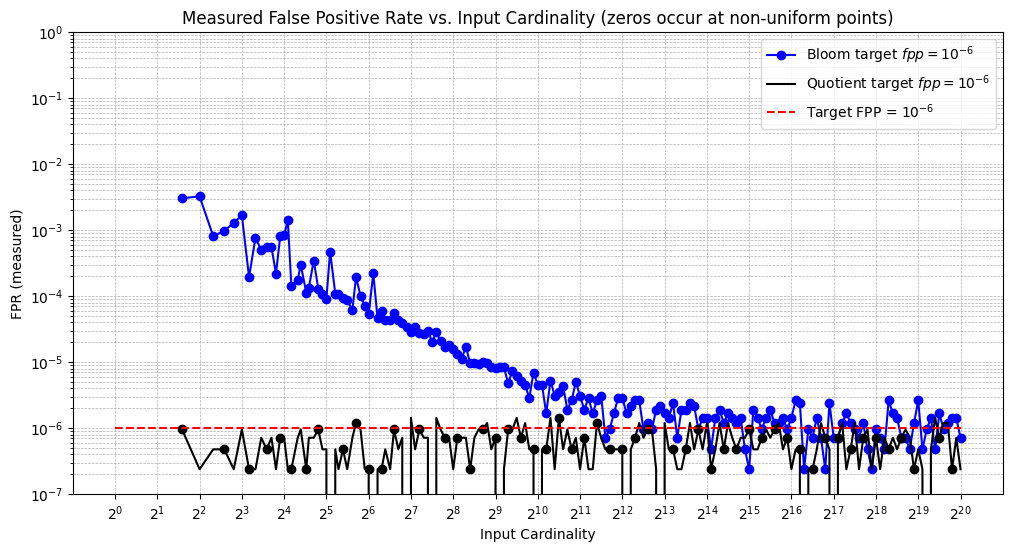

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(bf_sizes["inputCardinality"], bf_sizes["FalsePositiveRate"], color="blue", marker="o", label=r"Bloom target $fpp = 10^{-6}$")

# Quotient 
ax.plot(qf_sizes["inputCardinality"], qf_sizes["FalsePositiveRate"], color="black", label=r"Quotient target $fpp = 10^{-6}$")
ax.plot(qf_sizes["inputCardinality"][::3], qf_sizes["FalsePositiveRate"][::3], color="black", marker="o", linestyle="None") # just for markers ::3 aribitrarily chosen.

xvals = np.array([2**j for j in range(21)])
ax.plot(xvals, (1e-6)*np.ones_like(xvals), label="Target FPP = $10^{-6}$", color="red", linestyle="--")
ax.legend()
ax.grid()
ax.set_yscale("log", base=10)
ax.set_ylim(1e-7, 1)
ax.set_xscale("log", base=2)
ax.set_xticks([2**i for i in range(0, 21)])
ax.set_ylabel("FPR (measured)")
ax.set_xlabel("Input Cardinality")
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.set_title("Measured False Positive Rate vs. Input Cardinality (zeros occur at non-uniform points)")


## Experiment 2. Changing the false positive rate

We repeat the above with a larger false positive rate.  The main 
takeaway is that the Quotient filter is less attractive in this setting, consistent with prior plots.

In [14]:
bf_sizes_1e3 = parse_size_results("1e-3/BloomFilterSizeProfile20240703_045451PST.txt")
qf_sizes_1e3 = parse_size_results("1e-3/QuotientFilterSizeProfile20240703_045733PST.txt")

for df in [bf_sizes_1e3, qf_sizes_1e3]:
    df["bitsPerElement"] = df["Size"] / df["inputCardinality"]

for qf in [qf_sizes_1e3]:
    qf["numSlots"] = np.ceil(np.log2(qf["inputCardinality"] / 0.9 )).astype(int) # nb this is because the suggestion function always uses 0.9 and may change in futuer.
    qf["loadFactor"] = qf["inputCardinality"] / (2**qf["numSlots"])

In [15]:
qf_sizes_1e3

,inputCardinality,Size,NumTrials,FalsePositiveRate,NumHashBits,bitsPerElement,numSlots,loadFactor
0,3,96,16384,0.000244,10,32.000000,2,0.750000
1,4,104,10922,0.000732,10,26.000000,3,0.500000
2,5,104,8192,0.000488,10,20.800000,3,0.625000
3,6,104,6553,0.000244,10,17.333333,3,0.750000
4,7,192,5461,0.000732,10,27.428571,3,0.875000
...,...,...,...,...,...,...,...,...
169,794672,13631488,1024,0.000000,10,17.153603,20,0.757858
170,851708,13631488,1024,0.000244,10,16.004884,20,0.812252
171,912838,13631488,1024,0.000977,10,14.933086,20,0.870550
172,978356,27262976,1024,0.000244,10,27.866110,21,0.466516


In [252]:
bf_sizes_1e3

,inputCardinality,Size,NumTrials,FalsePositiveRate,NumHashBits,bitsPerElement
0,3,64,16384,0.006104,11,21.333333
1,4,64,10922,0.016968,11,16.000000
2,5,128,8192,0.003174,10,25.600000
3,6,128,6553,0.002930,11,21.333333
4,7,128,5461,0.002808,11,18.285714
...,...,...,...,...,...,...
169,794672,11425472,1024,0.000488,10,14.377595
170,851708,12245568,1024,0.001465,10,14.377660
171,912838,13124416,1024,0.001465,10,14.377596
172,978356,14066432,1024,0.001709,10,14.377621


Text(0.5, 1.0, 'Size (bits) vs Input Cardinality')

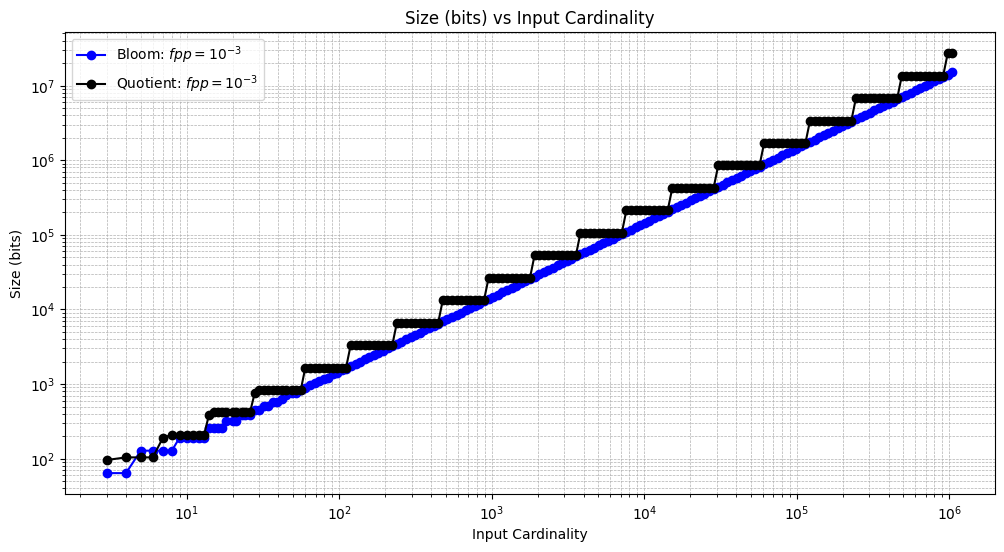

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
SCALE = 1
ax.plot(bf_sizes_1e3["inputCardinality"], bf_sizes_1e3["Size"]/SCALE, color="blue", marker="o", label=r"Bloom: $fpp = 10^{-3}$")

# Quotient 
ax.plot(qf_sizes_1e3["inputCardinality"], qf_sizes_1e3["Size"]/SCALE, color="black", marker="o", label=r"Quotient: $fpp = 10^{-3}$")


ax.legend()
ax.grid()
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_ylabel("Size (bits)")
ax.set_xlabel("Input Cardinality")
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.set_title("Size (bits) vs Input Cardinality")


Text(0.5, 1.0, 'Size ratio of Bloom Filter to Quotient Filter')

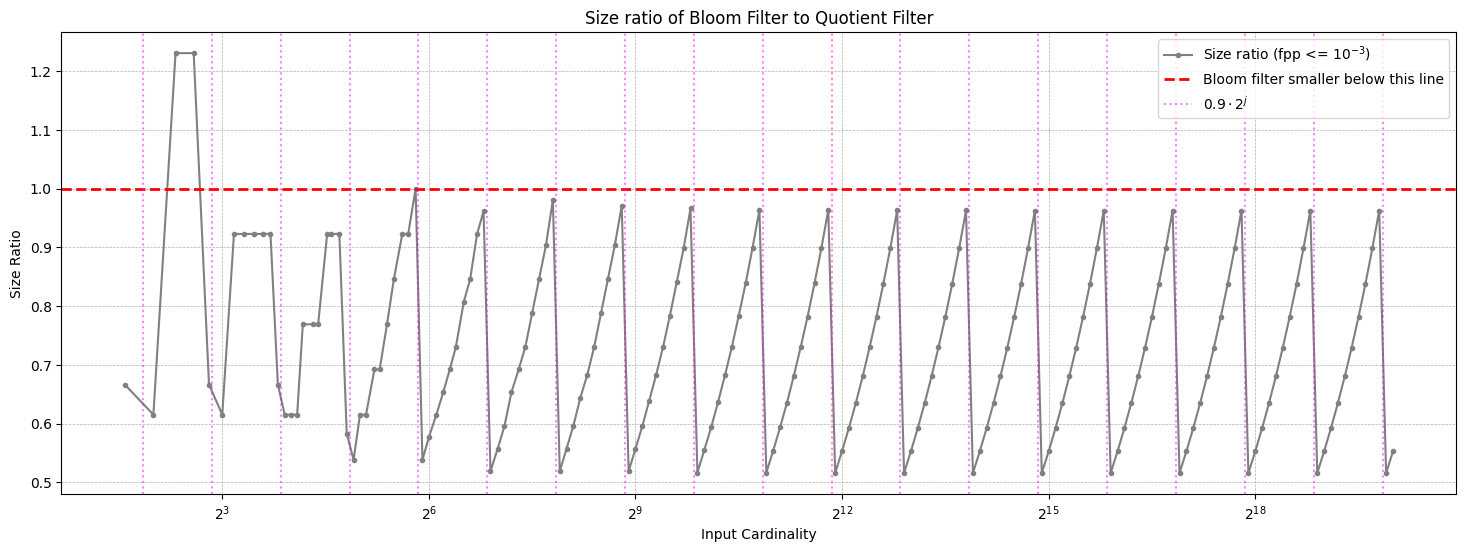

In [17]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(bf_sizes_1e3["inputCardinality"], bf_sizes_1e3["Size"]/qf_sizes_1e3["Size"], color="grey", marker=".", label=r"Size ratio (fpp <= $10^{-3}$)")
ax.axhline(y=1, color='red', linestyle='--', linewidth=2, label='Bloom filter smaller below this line')

# Plot vertical lines at 0.9*2^j for each j
j_values = range(2, 21)
jval_col = "magenta"
for i, j in enumerate(j_values):
    x = 0.9 * 2**j
    if i == len(j_values) - 1:
        ax.axvline(x=x, color=jval_col, linestyle=':', alpha=0.5, label=r"$0.9 \cdot 2^j$")
    else:
        ax.axvline(x=x, color=jval_col, linestyle=':', alpha=0.5)


ax.legend()
ax.grid()
ax.set_xscale("log", base=2)
ax.set_ylabel("Size Ratio")
ax.set_xlabel("Input Cardinality")
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.set_title("Size ratio of Bloom Filter to Quotient Filter")

Text(0.5, 1.0, 'Measured False Positive Rate vs. Input Cardinality (zeros occur at non-uniform points)')

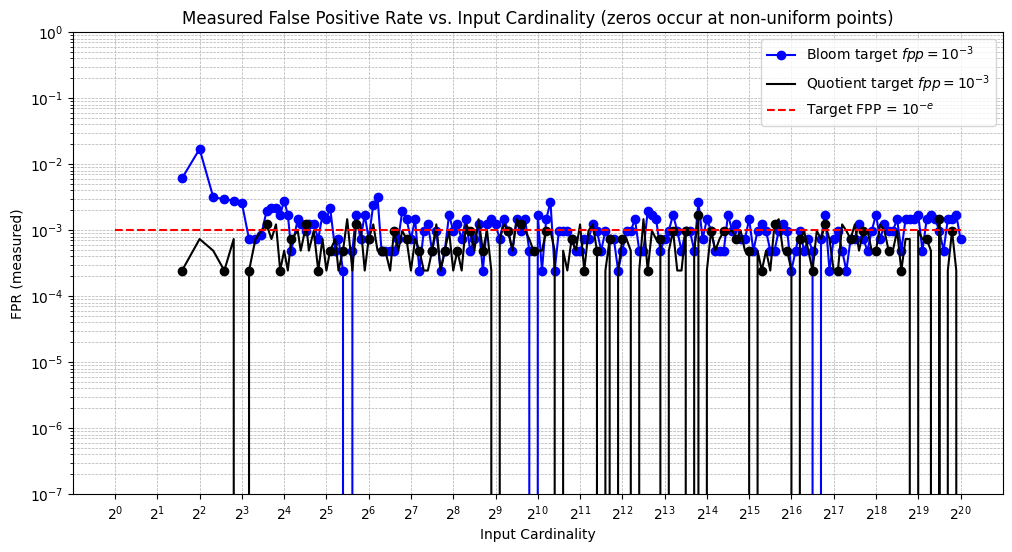

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(bf_sizes_1e3["inputCardinality"], bf_sizes_1e3["FalsePositiveRate"], color="blue", marker="o", label=r"Bloom target $fpp = 10^{-3}$")

# Quotient 
ax.plot(qf_sizes_1e3["inputCardinality"], qf_sizes_1e3["FalsePositiveRate"], color="black", label=r"Quotient target $fpp = 10^{-3}$")
ax.plot(qf_sizes_1e3["inputCardinality"][::3], qf_sizes_1e3["FalsePositiveRate"][::3], color="black", marker="o", linestyle="None") 

xvals = np.array([2**j for j in range(21)])
ax.plot(xvals, (1e-3)*np.ones_like(xvals), label="Target FPP = $10^{-e}$", color="red", linestyle="--")
ax.legend()
ax.grid()
ax.set_yscale("log", base=10)
ax.set_ylim(1e-7, 1)
ax.set_xscale("log", base=2)
ax.set_xticks([2**i for i in range(0, 21)])
ax.set_ylabel("FPR (measured)")
ax.set_xlabel("Input Cardinality")
ax.grid(which='both', linestyle='--', linewidth=0.5)
ax.set_title("Measured False Positive Rate vs. Input Cardinality (zeros occur at non-uniform points)")


From these plots we see roughly the same error behaviour as when the fpr is $1e-6$, however the gaps between the two filters have reduced.  This supports the theoretical understanding that if higher accuracy is desired then Quotient filter should be more strongly considered compared to at lower false positive rates.